In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_hub as hub
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Dataset

In [3]:
IMG_SIZE=256
BATCH_SIZE=32

In [4]:
def import_dataset(path, IMG_SIZE=256,BATCH_SIZE=32):
  dataset=tf.keras.preprocessing.image_dataset_from_directory(
      path,
      shuffle=True,
      image_size=(IMG_SIZE,IMG_SIZE),
      batch_size=BATCH_SIZE
  )
  return dataset

In [5]:
dataset=import_dataset("/content/drive/MyDrive/cotton disease_1",IMG_SIZE,BATCH_SIZE)

Found 154 files belonging to 4 classes.


# Visualization

In [6]:
class_names=dataset.class_names
print(class_names)

['diseased cotton leaf', 'diseased cotton plant', 'fresh cotton leaf', 'fresh cotton plant']


In [7]:
for image, label in dataset.take(1):
  print(image.shape)
  print(label.numpy())

(32, 256, 256, 3)
[0 0 1 0 0 0 0 0 0 0 0 0 0 3 0 2 0 3 0 0 0 0 0 0 2 0 0 0 0 0 0 2]


In [9]:
def visualize_data(dataset):
  plt.figure(figsize=(15,10))
  for image, label in dataset.take(1):
    for i in range(10):
      ax=plt.subplot(2,5,i+1)
      plt.imshow(image[i].numpy().astype("uint8"))
      plt.title(class_names[label[i]])
      plt.axis("off")


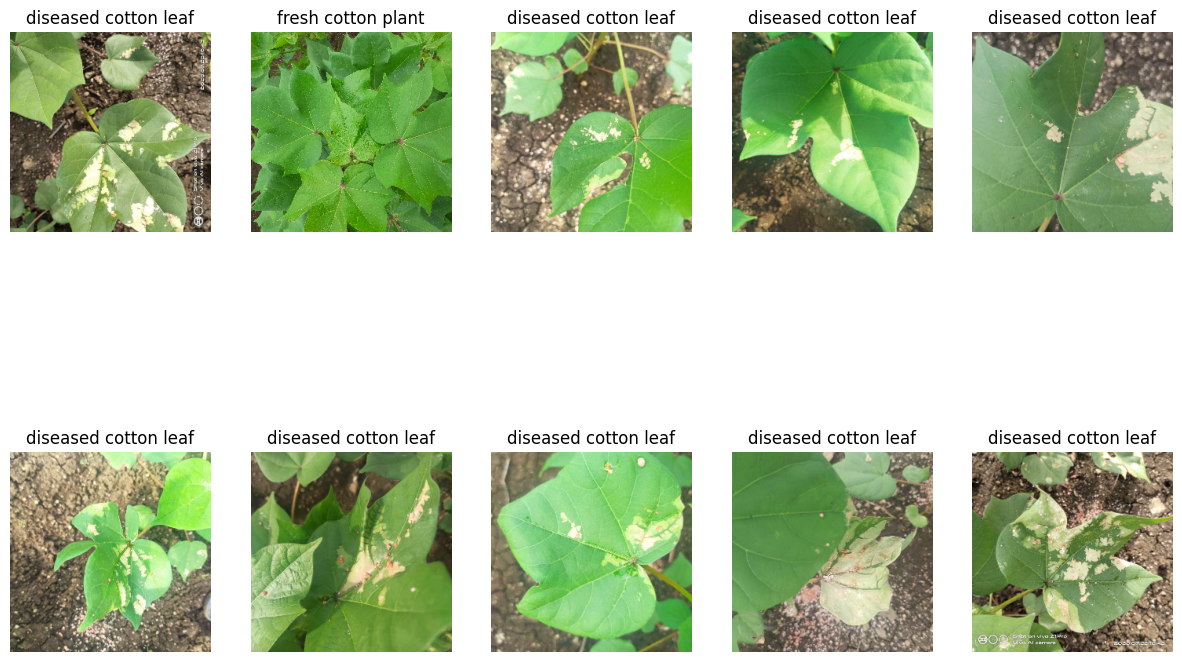

In [10]:
visualize_data(dataset)

# Split the Data

In [13]:
! pip install split-folders
import splitfolders

In [14]:
# import splitfolders

# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# splitfolders.ratio("/content/drive/MyDrive/cotton disease_1", output="/content/drive/MyDrive/DATASET",
#     seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

Copying files: 154 files [00:01, 105.83 files/s]


In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [26]:
IMAGE_SIZE=256
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=False,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=(0.0, 0.8)
)
train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/DATASET/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 122 images belonging to 4 classes.


In [18]:
train_generator.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [27]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=False,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=(0.0, 0.8))
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/MyDrive/DATASET/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 14 images belonging to 4 classes.


In [28]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=False,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=(0.0, 0.8))

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/DATASET/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 18 images belonging to 4 classes.


# Optimize the Data


In [22]:
# train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Build

# Model-1

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

## Compile

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

## Plot

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

## Save Model

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
model.save("/content/drive/MyDrive/DATASET/weights_1.h5")

# Model-2

In [29]:
import tensorflow as tf
import tensorflow_hub as hub


In [30]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models

# Load the pre-trained model from TensorFlow Hub
model1 = hub.KerasLayer("https://tfhub.dev/rishit-dagli/plant-disease/1", trainable=False)

NUM_CLASSES = 4  # Change this to the appropriate number of classes

model = models.Sequential([
    model1,

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Input shape should be (None, 224, 224, 3)
model.build(input_shape=(None, 224, 224, 3))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 38)                3267814   
                                                                 
 flatten (Flatten)           (None, 38)                0         
                                                                 
 dense (Dense)               (None, 256)               9984      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [31]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [33]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=30, verbose=1, batch_size=BATCH_SIZE)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 17s 1s/step - loss: 1.3043 - accuracy: 0.6803 - val_loss: 1.1346 - val_accuracy: 1.0000
Epoch 2/30
4/4 [==============================] - 5s 1s/step - loss: 1.0165 - accuracy: 0.9344 - val_loss: 0.7835 - val_accuracy: 1.0000
Epoch 3/30
4/4 [==============================] - 4s 912ms/step - loss: 0.6890 - accuracy: 0.9344 - val_loss: 0.3904 - val_accuracy: 1.0000
Epoch 4/30
4/4 [==============================] - 4s 891ms/step - loss: 0.4006 - accuracy: 0.9344 - val_loss: 0.0911 - val_accuracy: 1.0000
Epoch 5/30
4/4 [==============================] - 5s 1s/step - loss: 0.3412 - accuracy: 0.9344 - val_loss: 0.0184 - val_accuracy: 1.0000
Epoch 6/30
4/4 [==============================] - 4s 936ms/step - loss: 0.4008 - accuracy: 0.9344 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 7/30
3/4 [=====================>........] - ETA: 0s - loss: 0.4429 - accuracy: 0.9222

KeyboardInterrupt: ignored

In [ ]:
scores = model.evaluate(test_ds)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
EPOCHS = 30

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
import numpy as np

for image_batch, label_batch in test_generator:
    first_image = image_batch[0]
    first_label = int(label_batch[0])

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

    break


In [ ]:
model.save("../model_name.h5")